In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [178]:
import scipy
import pandas as pd
import seaborn as sns

import cv2
import skvideo.io
import imageio
import pytube

import os
import time
import csv
import re
import humanize
from tqdm import tqdm

from skimage.measure import compare_mse, compare_ssim
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import hamming

# Data

In [3]:
def folder_size(path='.'):
    total = 0
    for entry in os.scandir(path):
        if entry.is_file():
            total += entry.stat().st_size
        elif entry.is_dir():
            total += folder_size(entry.path)
    return humanize.naturalsize(total)

In [4]:
def video_to_image(video_loc, img_folder, dataset_type):
    raw = {}
    
    tqdm.write('Reading in video file ...')
    cap = skvideo.io.vread(video_loc)
    
    tqdm.write('Constructing dataset ...')
    for idx, frame in enumerate(tqdm(cap)):
        img_path = os.path.join(img_folder, str(idx)+'.jpg')
        raw[idx] = [img_path, idx]
        skvideo.io.vwrite(img_path, frame)
    
    raw_df = pd.DataFrame.from_dict(raw, orient='index')
    raw_df.columns = ['img_path', 'img_index']
    
    tqdm.write('Writing raw to csv')
    raw_df.to_csv(os.path.join(data_path, dataset_type+'_raw.csv'), index=False)
    
    return 'Done'

In [5]:
def video_to_image2(video_loc, img_folder, dataset_type, start_idx=0, end_idx=100000, img_quality=90):
    raw = {}
    
    cap = cv2.VideoCapture(video_loc)
    idx = 0
    ret = True
    while ret:
        ret, frame = cap.read()
        if idx > start_idx:
            img_path = os.path.join(img_folder, str(idx)+'.jpg')
            raw[idx] = [img_path, idx]
            frame = cv2.flip(frame, -1)
            cv2.imwrite(img_path, frame, [cv2.IMWRITE_JPEG_QUALITY, img_quality])
        idx += 1
        if idx == end_idx:
            break
    cap.release()
    
    print('Done with %d frames' % (end_idx - start_idx - 1))
    print('Start index: ', start_idx)
    print('End index: ', end_idx)
    
    raw_df = pd.DataFrame.from_dict(raw, orient='index')
    raw_df.columns = ['img_path', 'img_index']
    raw_df.to_csv(os.path.join(data_path, dataset_type+'_raw.csv'), index=False)

In [6]:
save_path = '/home/idies/workspace/Storage/Cong/persistent/video/data'
data_path = '/home/idies/workspace/Storage/Cong/persistent/video/data'
result_path = '/home/idies/workspace/Storage/Cong/persistent/video/result'

In [6]:
train_video = os.path.join(data_path, 'LapTimer-20180624-091108.mp4')
train_imgs = os.path.join(data_path, 'imgs091108')

In [83]:
video_to_image2(train_video, train_imgs, 'train091108', 3450, 27970, 30)

Done with 24519 frames.
Start index:  3450
End index:  27970
Writing raw to csv


In [29]:
train_df = pd.read_csv(os.path.join(data_path, 'train091108_raw.csv'))
train_df.shape

(24519, 2)

Shape:  (1080, 1920, 3)


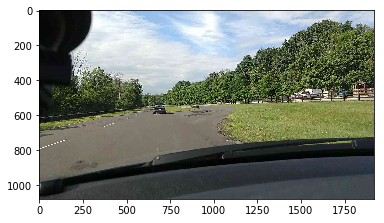

In [33]:
img = imread(train_df['img_path'][0])
print('Shape: ', img.shape)
imshow(img);

In [38]:
train_video = os.path.join(data_path, 'LapTimer-20180624-153240.mp4')
train_imgs = os.path.join(data_path, 'imgs153240')

In [39]:
video_to_image2(train_video, train_imgs, 'train153240', 3000, 32760, 30)

Done with 29759 frames
Start index:  3000
End index:  32760


In [40]:
train_df = pd.read_csv(os.path.join(data_path, 'train153240_raw.csv'))
train_df.shape

(29759, 2)

Shape:  (1080, 1920, 3)


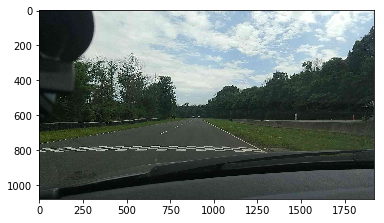

In [42]:
img = imread(train_df['img_path'][0])
print('Shape: ', img.shape)
imshow(img);

# Preprocessing

In [7]:
def image_crop(h1, h2, l1, l2, original):
    return original[h1:h2, l1:l2, :]

In [10]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [14]:
bright_factor = 0.2 + np.random.uniform()
bright_factor

1.0426016233980548

In [7]:
train_df = pd.read_csv(os.path.join(data_path, 'train091108_raw.csv'))
train_df.shape

(24519, 2)

Shape:  (1080, 1920, 3)


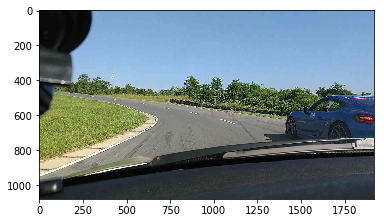

In [31]:
img = imread(train_df['img_path'][20000])
print('Shape: ', img.shape)
imshow(img);

Shape:  (360, 1670, 3)


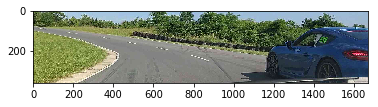

In [32]:
img1 = image_crop(400, 760, 250, 1920, img)
print('Shape: ', img1.shape)
imshow(img1);

In [ ]:
train_df = pd.read_csv(os.path.join(data_path, 'train153240_raw.csv'))
train_df.shape

Shape:  (1080, 1920, 3)


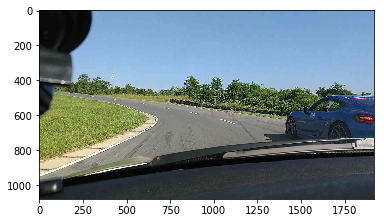

In [31]:
img = imread(train_df['img_path'][20000])
print('Shape: ', img.shape)
imshow(img);

Shape:  (360, 1670, 3)


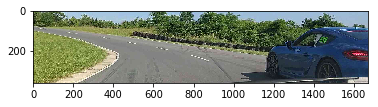

In [32]:
img1 = image_crop(400, 760, 250, 1920, img)
print('Shape: ', img1.shape)
imshow(img1);

# FPS

In [8]:
def get_FPS(video_loc):
    video = cv2.VideoCapture(video_loc)
    fps = video.get(cv2.CAP_PROP_FPS)
    return fps

In [9]:
get_FPS(train_video)

29.93930396046777

In [58]:
video = cv2.VideoCapture(train_video)
video.get(cv2.CAP_PROP_FRAME_COUNT)

30070.0

In [74]:
(30070 - 3450 - 2100) * 180 / 1024 / 1024

4.209136962890625

In [20]:
get_FPS(train_video)

29.93943500598125

In [21]:
video = cv2.VideoCapture(train_video)
video.get(cv2.CAP_PROP_FRAME_COUNT)

36523.0

In [37]:
(36523 - 3000 - 3763) * 100 / 1024 / 1024

2.838134765625

# Image Similarity

In [9]:
def get_histogram(img):
    h, w = img.shape
    hist = [0.0] * 256
    for i in range(h):
        for j in range(w):
            hist[img[i, j]] += 1
    return np.array(hist) / (h * w)

In [10]:
def normalize_exposure(img):
    '''
    Normalize the exposure of an image.
    '''
    img = img.astype(int)
    hist = get_histogram(img)
    # get the sum of vals accumulated by each position in hist
    cdf = np.array([sum(hist[:i+1]) for i in range(len(hist))])
    # determine the normalization values for each unit of the cdf
    sk = np.uint8(255 * cdf)
    # normalize each position in the output image
    h, w = img.shape
    normalized = np.zeros_like(img)
    for i in range(0, h):
        for j in range(0, w):
            normalized[i, j] = sk[img[i, j]]
    return normalized.astype(int)

In [11]:
def compare_emd(img1, img2):
    img1 = normalize_exposure(img1)
    img2 = normalize_exposure(img2)
    return wasserstein_distance(get_histogram(img1), get_histogram(img2))

In [12]:
def compare_orb(img1, img2, threshold):
    orb = cv2.ORB_create()
    kp_1, desc_1 = orb.detectAndCompute(img1, None)
    kp_2, desc_2 = orb.detectAndCompute(img2, None)
    if desc_1 is None or desc_2 is None:
        return 0
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desc_1, desc_2)
    if len(matches) == 0:
        return 0
    similar = [i for i in matches if i.distance < threshold]
    return len(similar) / len(matches)

In [13]:
def dhash(img, hashSize=8):
    # resize the input image, adding a single column (row) so we can compute the gradient
    resized_col = cv2.resize(img, (hashSize+1,hashSize))
    resized_row = cv2.resize(img, (hashSize,hashSize+1))
 
    # compute the (relative) gradient between adjacent pixels
    diff_col = resized_col[:,1:] > resized_col[:,:-1]
    diff_row = resized_row[1:,:] > resized_row[:-1,:]

    # convert the difference image to a hash
    return sum([2**i for (i, v) in enumerate(np.append(diff_col.flatten(), diff_row.flatten())) if v])

In [14]:
def compare_dhash(img1, img2, hashSize=8):
    h1 = [int(d) for d in str(int(dhash(img1)))]
    h2 = [int(d) for d in str(int(dhash(img2)))]
    
    if len(h1) == len(h2):
        dHash = hamming(h1, h2)
    else:
        dHash = 1
    return dHash

In [173]:
def compare_phash(img1, img2):
    phash = cv2.img_hash_PHash.create()
    return phash.compare(phash.compute(img1), phash.compute(img2))

In [225]:
def get_similar_image(img, image_df, method, ascending, start, end, h1, h2, l1, l2):
    results_dict = {}
    img = image_crop(h1, h2, l1, l2, img)
    if method == 'EMD' or method == 'ORB' or method == 'dHash':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    for i in range(start, min(end, image_df.shape[0])):
        #i = i - image_df['img_index'][0]
        temp_img = imread(image_df['img_path'][i])
        temp_img = image_crop(h1, h2, l1, l2, temp_img)
        if method == 'MSE':
            results_dict[i] = [image_df['img_path'][i], image_df['img_index'][i], compare_mse(img, temp_img)]
        elif method == 'EMD':
            temp_img = cv2.cvtColor(temp_img, cv2.COLOR_RGB2GRAY)
            results_dict[i] = [image_df['img_path'][i], image_df['img_index'][i], compare_emd(img, temp_img)]
        elif method == 'ORB':
            temp_img = cv2.cvtColor(temp_img, cv2.COLOR_RGB2GRAY)
            results_dict[i] = [image_df['img_path'][i], image_df['img_index'][i], compare_orb(img, temp_img, threshold)]
        elif method == 'dHash':
            temp_img = cv2.cvtColor(temp_img, cv2.COLOR_RGB2GRAY)
            results_dict[i] = [image_df['img_path'][i], image_df['img_index'][i], compare_dhash(img, temp_img)]
        elif method == 'pHash':
            results_dict[i] = [image_df['img_path'][i], image_df['img_index'][i], compare_phash(img, temp_img)]
        else:
            results_dict[i] = [image_df['img_path'][i], image_df['img_index'][i], compare_ssim(img, temp_img, multichannel=True)]
    
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')
    results_df.columns = ['img_path', 'img_index', method]
    results_df = results_df.sort_values(by=method, ascending=ascending)
    return results_df

In [189]:
def weighted_index(df, n, method, ascending):
    temp = df.copy()[:n]
    if ascending:
        temp['weight'] = (1/temp[method]) / sum(1/temp[method])
    else:
        temp['weight'] = temp[method] / sum(temp[method])
    return sum(temp['img_index']*temp['weight'])

In [190]:
prior_time = 60
sample_frac = 0.8
threshold = 70

In [79]:
train_df = pd.read_csv(os.path.join(data_path, 'train091108_raw.csv'))
train_df.shape

(24519, 2)

In [80]:
img = imread(train_df['img_path'][0])
test_mse = get_similar_image(img, train_df, 'MSE', True, 5250, 7000, 400, 760, 250, 1920)
test_mse.to_csv(os.path.join(result_path, '091108', 'MSE.csv'), index=False)

Shape:  (1080, 1920, 3)


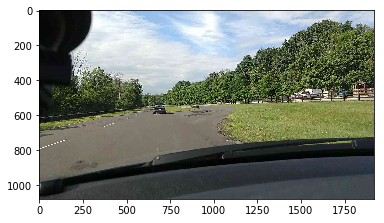

Shape:  (1080, 1920, 3)


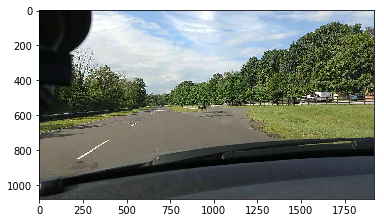

In [83]:
for idx in [0, 2762]:
    img = imread(train_df['img_path'][idx])
    print('Shape: ', img.shape)
    plt.imshow(img);
    plt.show();

In [177]:
img1 = imread(train_df['img_path'][0])
img1 = image_crop(400, 760, 250, 1920, img1)
img2 = imread(train_df['img_path'][2762])
img2 = image_crop(400, 760, 250, 1920, img2)
print(dhash(img1))
print(dhash(img2))
print(compare_dhash(img1, img2))
print(compare_phash(img1, img2))

375177039564486845129600453906583440632807036070413901274276213903224981027685977553749890284331821243724976062527
538706312398239033461152264796470670642382725036516946446030053600620587378201501696743442236935556396792517197887
0.8508771929824561
10.0


# Lap Time

In [18]:
def lap_time(initial_idx, sample, sample_frac, fps, topn, df, method, ascending, h1, h2, l1, l2, seed):
    np.random.seed(seed)
    results_dict = {}
    prior = initial_idx + np.floor(prior_time * fps).astype(int)
    img_idxs = np.random.choice(np.arange(initial_idx, np.floor(initial_idx+fps).astype(int)), np.round(sample*sample_frac).astype(int), replace=False).tolist() + np.random.choice(np.arange(np.ceil(initial_idx+fps).astype(int), np.floor(initial_idx+2*fps).astype(int)), np.round(sample*(1-sample_frac)).astype(int), replace=False).tolist()
    
    for idx in img_idxs:
        img = imread(df['img_path'][idx])
        similar_imgs = get_similar_image(img, df, method, ascending, prior, h1, h2, l1, l2)
        results_dict[idx] = [df['img_path'][idx], idx, (similar_imgs['img_index'].iloc[0]-idx)/fps, (weighted_index(similar_imgs, topn, method, ascending)-idx)/fps]
    
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')
    results_df.columns = ['img_path', 'img_index', 'lap_time', 'weighted_lap_time']
    return results_df

In [226]:
def lap_time2(initial_idx, end, fps, topn, df, method, ascending, h1, h2, l1, l2):
    results_dict = {}
    start = initial_idx + np.round(fps*prior_time).astype(int)
    img_idxs = np.arange(initial_idx, np.round(initial_idx+fps).astype(int)).tolist()
    #img_idxs = np.choice(np.arange(initial_idx, np.round(initial_idx+fps).astype(int)), 10).tolist()
    
    for idx in img_idxs:
        img = imread(df['img_path'][idx])
        start_time = time.time()
        similar_imgs = get_similar_image(img, df, method, ascending, start, end, h1, h2, l1, l2)
        elapsedTime = time.time() - start_time
        results_dict[idx] = [df['img_path'][idx], df['img_index'][idx], (similar_imgs['img_index'].iloc[0]-df['img_index'][idx])/fps, (weighted_index(similar_imgs, topn, method, ascending)-df['img_index'][idx])/fps, elapsedTime, method]
    
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')
    results_df.columns = ['img_path', 'img_index', 'lap_time', 'weighted_lap_time', 'elapsedTime', 'method']
    return results_df

In [244]:
def laps(initial_idx, end, fps, topn, df, method, ascending, h1, h2, l1, l2, maxlap=100000):
    lap_time = pd.DataFrame()
    start = initial_idx + np.round(fps*prior_time).astype(int)
    lap = 1
    
    while start < df.shape[0] and lap <= maxlap:
        temp = lap_time2(initial_idx, end, fps, topn, df, method, ascending, h1, h2, l1, l2)
        temp['lap'] = lap
        lap_time = lap_time.append(temp)
        lap += 1
        initial_idx += int(temp['lap_time'].iloc[0] * fps)
        start = initial_idx + np.round(fps*prior_time).astype(int)
        estimated_time = np.mean(temp['lap_time'])
        end = int(start + estimated_time * fps)
    if maxlap == 100000:
        return lap_time
    else:
        return (lap_time, initial_idx, end)

In [224]:
train_df = pd.read_csv(os.path.join(data_path, 'train153240_raw.csv'))
train_df.shape

(29759, 2)

In [215]:
prior_time = 60
threshold = 70

In [245]:
df = pd.read_csv(os.path.join(data_path, 'train153240_raw.csv'))

initial_idx = 6447
end = 11328

fps = 29.93943500598125
topn = 5
maxlap = 2

method = 'dHash'
ascending = True

h1 = 400
h2 = 760
l1 = 250
l2 = 1920

In [ ]:
temp, initial_idx, end = laps(initial_idx, end, fps, topn, df, method, ascending, h1, h2, l1, l2, maxlap)
temp.to_csv(os.path.join(result_path, '153240', 'lap34_dHash.csv'), index=False)

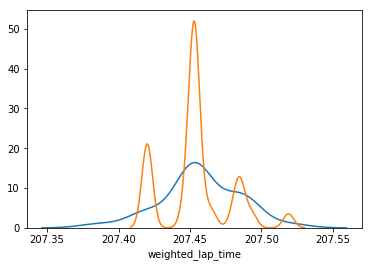

In [200]:
sns.distplot(test.lap_time, hist=False, norm_hist=True);
sns.distplot(test.weighted_lap_time, hist=False, norm_hist=True);